# Best arm identification with subgroups

## Simulation setting

In [1]:
import numpy as np

## define simulation parameters
K_ARMS = 3
L_SUB = 3

MEANS = np.array([[0.2,0.6,0.8],# means[k][l] for arm k and group l
                  [0.4,0.4,0.3],
                  [-0.2,1,1.5]])
BETAS = np.array([0.2,0.3,0.5]) # weight of the three subgroups
NOISE = 1

STEPSIZE = 1

## define the simulator
def Simulate(k,l):
    """ simulate an observation of arm k and subgroup l"""
    return np.random.normal(loc=MEANS[k][l],scale = NOISE)

def Simulate_rand(k):
    """ simulate an observation for arm k, random subgroup"""
    integers = np.arange(0,L_SUB)
    sub_id = np.random.choice(integers, p=BETAS)
    return sub_id,np.random.normal(loc=MEANS[k][sub_id],scale = NOISE)

def Simulate_completely_rand():
    """simulate an observation of a random arm and random subgroup"""
    arm_id = np.random.randint(0,K_ARMS)
    integers = np.arange(0,L_SUB)
    sub_id = np.random.choice(integers, p=BETAS)
    return arm_id,sub_id,np.random.normal(loc=MEANS[arm_id][sub_id],scale = NOISE)

## Information of Arms

In [2]:
class ArmInfo:
    def __init__(self, est_means, n_draws):
        # est_means: the estimated mean of each subgroup, np array of dim L_SUB
        # n_draws: the number of draws of each subgroup, np array of dim L_SUB
        
        ########## basic information
        self.est_means = est_means # the estimated mean values of each subgroup
        self.n_draws = n_draws # the number of draws of each subgroup
        self.arm_val = np.dot(self.est_means,BETAS)# the weighted average across all L subgroups
        
        ########## for stopping rule calculation
        self.stop_lams = self.est_means.copy() # the value of lambda for calculating the stopping rule
        ##### indicator of smallest subgroup, to check for feasibility
        self.min_subgroup = np.argmin(self.est_means)# the subgroup with minimum estimated mean
        self.min_subval = self.est_means[self.min_subgroup]# the minimum value of subgroup estimation
    
    def updateEst(self, l_sub, new_obs):
        """ each time we acquire a new observation for a subgroup. Information of the arm will be accordingly updated."""
        # l_sub: the subgroup that this new observation is assigned to 
        # new_obs: the new observation
        ############# update the basic information
        n = self.n_draws[l_sub]
        self.est_means[l_sub]=(self.est_means[l_sub]*n+new_obs)/(n+1)
        self.n_draws[l_sub]=n+1
        self.arm_val = np.dot(self.est_means,BETAS)
        
        ############# update the indicator of smallest subgroup
        self.min_subgroup = np.argmin(self.est_means)
        self.min_subval = self.est_means[self.min_subgroup] 
        
    def is_feasible(self):
        """
        indicate the feasibility of arm according to the current estimation. 
        Note that this is just according to the current estimation, and not considering probability constraints
        """
        if self.min_subval<0:
            return False
        else:
            return True

### The class for T-a-S strategy

In [3]:
class ArmTaS(ArmInfo):
    def __init__(self, est_means, n_draws):
        super().__init__(est_means, n_draws)
        ############## for weight calculation and tracking strategy
        self.weight = 1/K_ARMS
        self.weightsum = self.weight*np.sum(self.n_draws)
        self.score = self.weightsum
        
    def updateEst(self, l_sub, new_obs):
        super().updateEst(l_sub, new_obs)
        ############# for tracking strategy
        self.score = self.score-1
        
    def updateWeight(self,new_weight):
        """record the new optimal weight"""
        self.weight = new_weight
        self.weightsum = self.weightsum + new_weight
        self.score = self.score + new_weight

### The class for T-a-SCS strategy

In [4]:
class ArmTaSCS(ArmInfo):
    def __init__(self, est_means, n_draws):
        super().__init__(est_means, n_draws)
        ############## for weight calculation and tracking strategy
        self.weights = np.ones(L_SUB)/(K_ARMS*L_SUB)# initial w_kl 
        self.weightsums = self.weights*self.n_draws
        self.scores = self.weightsums.copy()
        self.lams = self.est_means.copy() # initial lambda_kl for calculating the optimal weights
        
    def updateEst(self, l_sub, new_obs):
        super().updateEst(l_sub, new_obs)
        ############# for tracking strategy
        self.scores[l_sub] = self.scores[l_sub]-1
        
    def updateWeights(self, new_weights):
        """record the new optimal weights"""
        self.weights = np.array(new_weights)
        self.weightsums = self.weightsums + new_weights
        self.scores = self.scores + new_weights

## Calculating Alter Set $\lambda$ and Weights ***

### Weight calculation for T-a-S

The traditional track and stop strategy does not consider information on the subgroup when calculating the optimal weight allocation. According to Kaufmann, in the Gaussian case, the optimal weight assignment to each arm can be calculated as follows:

Denote the current arm with maximum quality as arm 1, and define 
\begin{equation}
g_k(y)=(1+y)I_{1/(1+y)}(\mu_1,\mu_k),\quad x_k(y) = g_k^{-1}(y)
\end{equation} 
for $k\in[K]$ and $k\not=1$. Let $x_1=1$, where $\mu_k$ is the `arm_val` of arm $k$. We have
\begin{equation}
w^*_k=\frac{x_k}{\sum_{i\in[K]}x_k}
\end{equation}

Further according to Kaufmann, we can solve the values of $x_k$, $k\in[K]$ and $k\not=1$ by solving for a parameter $\theta$, where
\begin{equation}
\sum_{k=2}^K x_k^2=1\text{ and }\frac{x_k}{1+x_k}=\frac{\theta}{(\mu_1-\mu_k)^2},\text{ thus }\sum_{k=2}^K\frac{\theta^2}{((\mu_1-\mu_k)^2-\theta)^2}=1
\end{equation}
we solve for the value of $\theta$ for some $\theta\in(0,(\mu_1-\mu_2)^2)$, and plug in the previous equations to get the value of $x_k$ and $w^*_k$.

We can further choose to do a modification of weights, which is to create a $L^{\infty}$ projection of $w^*$ onto $\Sigma_K^\varepsilon=\left\{(w_1,w_2,\ldots,w_K)\in(\varepsilon,1):\sum_{k=1}^Kw_k=1\right\}$, where $\varepsilon_t=\frac{1}{2}(K^2+t)^{-1/2}$.

In [5]:
def projL_inf(weights, threshold):
    """do a L-infty projection of the weights onto the simplex of [weights>=threshold] while maintaining the sum to be 1"""
    # weights: numpy array, can be of 1-dimensional K_ARMS(T-a-S) or 2-dimensional K_ARMS*L_SUB(T-a-SSC)
    shape = weights.shape
    weights = weights.reshape(-1)
    L = weights.size
    
    sorted_indices = np.argsort(weights)# record the indices
    sorted_weights = weights[sorted_indices]
    
    # modify the sorted weights to the projected version
    new_weights = np.clip(sorted_weights,a_min = threshold,a_max = None)
    increment = np.sum(new_weights-sorted_weights)
    for i in range(L):
        if(sorted_weights[i]>threshold):
            average_inc = increment/(L-i)
            if(sorted_weights[i]-average_inc<threshold):
                increment = increment-(new_weights[i]-threshold)
                new_weights[i]=threshold
            else:
                break
    average_inc = increment/(L-i)
    new_weights[i:L] = new_weights[i:L]-average_inc
    
    # back to the orginal order and shape
    original_indices = np.argsort(sorted_indices)
    new_weights = new_weights[original_indices]
    new_weights = new_weights.reshape(shape)
    return new_weights 

In [6]:
from scipy.optimize import fsolve

def getWeightTaS(arms, best_id, second_id, proj=False, threshold=0):
    """calculate the optimal weight assignment of the T-a-S strategy, given current estimated values of arm quality"""
    # arms: a list with K_ARMS number of ArmTaS class instances
    # best_id and second_id: the index of the best and second best arms in the list, in terms of arm quality
    # proj: if true, do a L-infty projection onto the simplex with threshold epsilon
    
    M = (arms[best_id].arm_val-arms[second_id].arm_val)**2 # the upperbound of theta
    
    # solve for the value of theta
    def eqTheta(x):
        """to solve theta for sum-1=0"""
        s = 0
        for i in range(K_ARMS):
            if (i!=best_id):
                temp = x**2 / ((arms[best_id].arm_val-arms[i].arm_val)**2-x)**2
                s = s + temp
        return s-1
    
    def objTheta(x):
        """to add the range restriction of solution value to the previous function"""
        if x < 0 or x > M:  # out of range of acceptable solutions, give a penalty
            return abs(x - M/2)**2 
        else:
            return eqTheta(x)
        
    theta = fsolve(objTheta, x0=M/2)
    
    # plug-in theta to get the value of optimal weights 
    s = 1 # sum of x from 1 to k
    x_ks = np.zeros([K_ARMS]) # the values of x_k
    x_ks[best_id]=1
    for i in range(K_ARMS):
        if(i!=best_id):
            x_k = theta / ((arms[best_id].arm_val-arms[i].arm_val)**2-theta)
            x_ks[i] = x_k
            s = s+x_k
    new_weights = x_ks/s
    
    # if proj==True, do a projection of the weights
    if proj == True:
        new_weights = projL_inf(new_weights, threshold)
        
    for i in range(K_ARMS):
        arms[i].updateWeight(new_weights[i])

### Weight calculation for T-a-SCS

Given the current estimation of mean values of each arm on each subgroup, we calculate the Alter set and the optimal weights assigned to each of the arms and subgroups. Note that we need to solve the optimal weights $w^*$ by
\begin{equation}
    w^* = \arg\sup_{w\in\Sigma_k}\inf_{\lambda\in\text{Alt}(\mu)}\left(\sum_{k=1}^K w_kd(\mu_k,\lambda_k)\right)
\end{equation}
For the Gaussian case, we have $d(x,y)=(x-y)^2/(2\sigma^2)$, this gives
\begin{equation}
    w^* = \arg\sup_{w\in\Sigma_k}\inf_{\lambda\in\text{Alt}(\mu)}\left(\frac{1}{2\sigma^2}\sum_{k=1}^K\sum_{l=1}^L w_{kl}(\mu_{kl}-\lambda_{kl})^2\right)
\end{equation}
To calculate and maximize the function of weights
\begin{equation}
f(\{w_{kl}\}_{k\in[K],~l\in[L]})=\inf_{\lambda\in\text{Alt}(\mu)}\left(\frac{1}{2\sigma^2}\sum_{k=1}^K\sum_{l=1}^L w_{kl}(\mu_{kl}-\lambda_{kl})^2\right),
\end{equation}
 we first discuss the following 2 situations:

#### Given the estimation $\hat{\mathbf{\mu}}$, we have no feasible arms

In this case, we activate the arm 
\begin{equation}
a=\arg\min_{k\in\{1,2,\ldots, K\}}\sum_{l\in[L],~\hat{\mu}_{kl}~< ~0}w_{kl}\hat{\mu}_{kl}^2
\end{equation}
and set $\lambda_{al}=\max\{0,\hat{\mu}_{al}\}$. 

Under the weight constraint $\sum_{k\in[K],~l\in[L]}w_{kl}=1$, we directly have the optimal weight assignment strategy: denote the minimum subgroup mean of arm $k$ (over subgroups $l\in[L]$) as $\mu^*_k(<0)$, let $w_k(\mu_k^*)^2$ be equal over all $k=1,2,\ldots,K$, we get 
\begin{equation}
    w_k=\frac{1}{(\mu_k^*)^2}\left(\sum_{j=1}^K\frac{1}{(\mu_j^*)^2}\right)^{-1},
\end{equation}
assigned to the minimum subgroup of each arm $k$.

In [7]:
def weights_case1(arms):
    """return the optimal weights for T-a-SCS when there is no feasible arm"""
    # arms: list of classes 
    new_weights = np.zeros([K_ARMS,L_SUB])
    s = 0
    for i in range(K_ARMS):
        s = s + 1/(arms[i].min_subval)**2
    
    for i in range(K_ARMS):
        new_weights[i][arms[i].min_subgroup] = 1/(arms[i].min_subval**2) * (1/s)
    
    return new_weights

#### There is already one feasible arm $k=1$. 

In this situation, for any set of given weights $\{w_{kl}\}_{k\in[K],~l\in[L]}$, we calculate the function $f(\{w_{kl}\}_{k\in[K],~l\in[L]})$. Note that the value of $f$ (i.e., the optimal choice of $\lambda$ that minimizes the weighted sum corresponding to given weights) can be attained in exactly one of the following situations. 

##### The first choice is to activate another arm $a$, which becomes feasible and beats arm $1$.

If this case yields the most efficient choice of $\lambda$ for the given weights $\{w_{kl}\}_{k\in[K],~l\in[L]}$, we have
\begin{equation}
f_k(\{w_{kl}\}_{k\in[K],~l\in[L]})= \frac{1}{2\sigma^2}\min_{\lambda}\sum_lw_{1l}(\hat{\mu}_{1l}-\lambda_{1l})^2+\sum_lw_{kl}(\hat{\mu}_{kl}-\lambda_{kl})^2\text{ s.t. }\sum \beta_l\lambda_{kl}\ge\sum\beta_l\lambda_{1l},\lambda_{kl}\ge 0,
\end{equation}
for arm $k$, and $f=\min\{f_2,f_3,\ldots,f_K\}$, $a=\arg\min_{k\not=1,k\in[K]}f_k$. 

###### We write a function that can be used not only to calculate and update the lambda values here, but also later in computing the stopping rule.

In [8]:
import gurobipy as gp
def f_k(means_1, means_k, weights_1, weights_k, start_1, start_k):
    """compute and return the values of f_k(corresponding to arm k) and lambda via quadratic programming"""
    # means_1, means_k: the (estimated) values of mu_1 and mu_k, numpy array with L_SUB elements
    # weights_1, weights_k: current value of weights, can be the empirical weights(n_draws) or the near-optimal assigned weights
    ### we use the number 1 to denote the current best feasible arm
    
    model = gp.Model()
    
    # create decision variables
    l_1 = model.addVars(L_SUB,lb=0,vtype=gp.GRB.CONTINUOUS)
    l_k = model.addVars(L_SUB,lb=0,vtype=gp.GRB.CONTINUOUS)
    
    # set the objective function
    obj_p1 = gp.quicksum(weights_1[i]*(l_1[i]-means_1[i])**2 for i in range(L_SUB))
    obj_p2 = gp.quicksum(weights_k[i]*(l_k[i]-means_k[i])**2 for i in range(L_SUB))
    model.setObjective(obj_p1+obj_p2,sense=gp.GRB.MINIMIZE)
    
    # add constraints
    armVal_1 = gp.quicksum(l_1[i]*BETAS[i] for i in range(L_SUB))
    armVal_k = gp.quicksum(l_k[i]*BETAS[i] for i in range(L_SUB))
    model.addConstr(armVal_1<=armVal_k)
    
    # set the initial values
    l_1.start = start_1
    l_k.start = start_k
    
    # Optimize the model
    model.setParam('OutputFlag', 0)
    model.optimize()

    # Get the solution and update to the arms
    new_lams_1 = np.zeros([L_SUB])
    new_lams_k = np.zeros([L_SUB])
    for i in range(L_SUB):
        new_lams_1[i] = l_1[i].x
        new_lams_k[i] = l_k[i].x
    
    return model.objVal, new_lams_1, new_lams_k
    

##### The second choice is to make arm 1 infeasible

If this case yields the most efficient choice of $\lambda$ for the given weights $\{w_{kl}\}_{k\in[K],~l\in[L]}$, we have
\begin{equation}
f(\{w_{kl}\}_{k\in[K],~l\in[L]})=\frac{1}{2\sigma^2}\min_{l\in[L]}w_{1l}\hat{\mu}_{1l}^2
\end{equation}

In [9]:
def Infeas_sub(means_1, weights_1):
    """find the index of the subgroup corresponding to the value of f_1 at current weights, return the index and corresponding value"""
    temp = means_1**2 * weights_1
    index = np.argmin(temp)
    return temp[index], index

###### Given the result of lambda, update weights using Frank-Wolfe-like algorithm

In [10]:
def weights_case2(arms, best_id):
    """calculate the values of f and have lambda updated corresponding to the current weights"""
    
    new_weights = np.zeros([K_ARMS,L_SUB])
    subgradient = np.zeros([K_ARMS,L_SUB])
    
    # first calculate the value of f_1
    ### we use min_val and min_id to record the index of the minimum function value among {f_1...f_k}
    min_val, sub_1_id = Infeas_sub(arms[best_id].est_means, arms[best_id].weights)
    min_id = best_id
    
    # next calculate the values of f_k w.r.t. current weights
    for i in range(K_ARMS):
        new_weights[i] = arms[i].weights
        
        if(i!=best_id):
            means_1 = arms[best_id].est_means
            means_k = arms[i].est_means
            weights_1 = arms[best_id].weights
            weights_k = arms[i].weights
            start_1 = arms[best_id].lams
            start_k = arms[i].lams
            f_val, arm1_lam, arms[i].lams = f_k(means_1, means_k, weights_1, weights_k, start_1, start_k)
    
            if(f_val<min_val):
                min_val = f_val
                min_id = i
                arms[best_id].lams = arm1_lam
                           
    # calculate the subgradient w.r.t. min_id
    if (min_id != best_id):
        subgradient[min_id] = (arms[min_id].lams - arms[min_id].est_means)**2/(2*NOISE**2)
        subgradient[best_id] = (arms[best_id].lams - arms[best_id].est_means)**2/(2*NOISE**2)
    else:
        subgradient[min_id][sub_1_id] = arms[min_id].est_means[sub_1_id]**2/(2*NOISE**2)
    
    # update the weights via subgradient ascent
    new_weights = new_weights + STEPSIZE*subgradient
    
    # modification and projection
    ### first project the weights to the simplex of sum=1
    disc = (np.sum(new_weights)-1)/(K_ARMS*L_SUB)
    new_weights = new_weights-disc
    ### next project to the nonnegative orthant while maintaining the sum
    new_weights = projL_inf(new_weights, 0)
    
    return new_weights

###### Summarizing the two cases, we get the following weight updating function for T-a-SCS

In [11]:
def findBestFeas(arms):
    """given current estimation, find the best feasible arm"""
    best_val = -1
    best_id = -1
    for i in range(K_ARMS):
        if(arms[i].is_feasible() and arms[i].arm_val>best_val):
            best_val = arms[i].arm_val
            best_id = i
    return best_id   

In [12]:
def getWeightsTaSCS(arms, proj=False, threshold=0):
    """calculate the optimal weight assignment of the T-a-SCS strategy, given current estimated values of arm quality"""
    best_id = findBestFeas(arms)
    if best_id == -1:
        new_weights = weights_case1(arms)
    else:
        new_weights = weights_case2(arms,best_id)
    
    # if proj==True, do a projection of the weights
    if proj == True:
        new_weights = projL_inf(new_weights, threshold)
        
    for i in range(K_ARMS):
        arms[i].updateWeights(new_weights[i])

## Choosing the next arm to sample

In [13]:
def C_tracking_TaS(arms):
    """find the arm with maximum score"""
    arm_scores = np.zeros([K_ARMS])
    for i in range(K_ARMS):
        arm_scores[i]=arms[i].score
            
    max_score_id = np.argmax(arm_scores)
    return max_score_id

In [14]:
def C_tracking_TaSCS(arms):
    """find the arm and subgroup with maximum score"""
    arm_scores = np.zeros([K_ARMS,L_SUB])
    for i in range(K_ARMS):
        arm_scores[i]=arms[i].scores
            
    max_score_id = np.unravel_index(np.argmax(arm_scores), arm_scores.shape)
    return max_score_id

## Stopping Rule

We also consider Chernoff's Generalized Likelihood Ratio statistic:
\begin{equation}
Z(t)=\frac{1}{2\sigma^2}\inf_{{\lambda}\in \text{Alt}({\mu})}\sum_{k\in[K]}\sum_{l\in[L]}N_{k,l}(t)\left(\hat\mu_{k,l}(t)-\lambda_{k,l}\right)^2.
\end{equation}
We stop the algorithm when $Z(t)>\beta(t,\delta)$, where $\beta(t,\delta)=\log((1+\log t)/\delta)$.

To calculate $Z(t)$, a similar approach of calculating $\lambda$ for T-a-SCs is implemented. Note that $Z(t)$ can be viewed as similarly a function of $w$ as $f(\{w_{kl}\}_{k\in[K],~l\in[L]})$, where $w$ is now the empirical weights corresponding to the number of samples at arm $k$ and subgroup $l$.

In [15]:
def stopRule(arms, t, delta):
    """given current estimations, number of draws and iteration step, decide whether to stop"""
    # threshold value
    threshold = np.log((np.log(t)+1)/delta)
    
    # find the current best feasible arm
    best_id = findBestFeas(arms)
    
    # case1: all arms infeasible
    if(best_id==-1):
        min_val = float('inf')
        for i in range(K_ARMS):
            neg_means = np.clip(arms[i].est_means,a_min=None,a_max=0)
            f_val = np.dot(neg_means**2,arms[i].n_draws)/(2*NOISE**2)
            if f_val < min_val:
                min_val= f_val
        
        if(min_val>threshold):
            return -2
        else:
            return -1
        
    # case2: one feasible arm
    else:
        # calculate the general likelihood ratio test statistics
        # first calculate the value of f_1
        ### we use min_val and min_id to record the index of the minimum function value among {f_1...f_k}
        min_val, sub_1_id = Infeas_sub(arms[best_id].est_means, arms[best_id].n_draws)
        min_id = best_id
    
        # next calculate the values of f_k w.r.t. current weights
        for i in range(K_ARMS):
            if(i!=best_id):
                means_1 = arms[best_id].est_means
                means_k = arms[i].est_means
                weights_1 = arms[best_id].n_draws
                weights_k = arms[i].n_draws
                start_1 = arms[best_id].stop_lams
                start_k = arms[i].stop_lams
                f_val, arm1_lam, arms[i].stop_lams = f_k(means_1, means_k, weights_1, weights_k, start_1, start_k)
    
                if(f_val<min_val):
                    min_val = f_val
                    min_id = i
                    arms[best_id].stop_lams = arm1_lam
            
        if(min_val>threshold):
            return best_id
        else:
            return -1

## Main Iteration

In [16]:
def get_top_two_array(arr):
    # Get the indexes of the two largest values
    idx = np.argpartition(arr, -2)[-2:]
    
    # Sort the indexes in descending order
    idx_sorted = idx[np.argsort(arr[idx])][::-1]
    
    return idx_sorted[0], idx_sorted[1]

In [17]:
def get_top_two_class(arms):
    sorted_indexes = sorted(enumerate(arms), key=lambda x: x[1].arm_val, reverse=True)
    return sorted_indexes[0][0], sorted_indexes[1][0]  

### Initialization of arms

In [18]:
Initial_Draws = 5

def Initialize(strategy):
    arms=[]
    for i in range(K_ARMS):
        est_means = np.zeros(L_SUB)
        n_draws = np.ones(L_SUB)*Initial_Draws
        for j in range(L_SUB):
            s = 0
            for t in range(Initial_Draws):
                s = s+Simulate(i,j)
            s = s/Initial_Draws
            est_means[j] = s
        if (strategy=="Uniform"):
            arm_i = ArmInfo(est_means,n_draws)
        elif(strategy== "TaS"):
            arm_i = ArmTaS(est_means,n_draws)
        elif(strategy=="TaSCS"):
            arm_i = ArmTaSCS(est_means,n_draws)
        else:
            print("strategy not exist!")
            return 0
        arms.append(arm_i)
    return arms

### Main experiment

In [19]:
def exp_main(delta, maxit,strategy):
    arms = Initialize(strategy)
    for t in range(K_ARMS*L_SUB*Initial_Draws + 1, K_ARMS*L_SUB*Initial_Draws + maxit):
    
        if strategy=="TaSCS":
            # Update the weights
            getWeightsTaSCS(arms, proj=True, threshold=1/(2*np.sqrt(K_ARMS*L_SUB**2+t)))
        
            # Simulate and update observation
            sample_id = C_tracking_TaSCS(arms)
            new_obs = Simulate(sample_id[0],sample_id[1])
            arms[sample_id[0]].updateEst(sample_id[1],new_obs)
            
        elif strategy =="TaS":
            # Update the weights
            best_id, second_id = get_top_two_class(arms)
            getWeightTaS(arms, best_id, second_id, proj=True, threshold=1/(2*np.sqrt(K_ARMS**2+t)))
            
            # Simulate and update observation
            sample_id = C_tracking_TaS(arms)
            new_obs = Simulate_rand(sample_id)
            arms[sample_id].updateEst(new_obs[0],new_obs[1])
            
        elif strategy =="Uniform":
            # Simulate and update observation
            new_obs = Simulate_completely_rand()
            arms[new_obs[0]].updateEst(new_obs[1],new_obs[2])     
    
        # Check stopping rule
        arm_id = stopRule(arms,t,delta)
        if arm_id==-2:
            #print("all infeasible")
            break
        if arm_id!=-1:
            #print("the best feasible arm is",arm_id)
            break
    return t,arms,arm_id

### Results

In [20]:
import progressbar

COPIES = 300
times = np.zeros([COPIES])
draw_props = np.zeros([COPIES,K_ARMS,L_SUB])
arm_ids = np.zeros([COPIES])
for c in progressbar.progressbar(range(COPIES)):
    t,arms,arm_id = exp_main(0.1,100000,"TaS")
    times[c] = t
    arm_ids[c]=arm_id
    s = 0
    for i in range(K_ARMS):
        s = s+np.sum(arms[i].n_draws)
    for i in range(K_ARMS):
        draw_props[c,i] = arms[i].n_draws/s           

Restricted license - for non-production use only - expires 2024-10-28


In [24]:
from tqdm import tqdm


ModuleNotFoundError: No module named 'progressbar'

#### The average iteration time

In [21]:
np.mean(times)

1703.18

#### Probability of wrong selection

In [22]:
True_best = 0
false_selection = np.count_nonzero(arm_ids!=True_best)
1-false_selection/COPIES

0.99

#### Average weight assignment

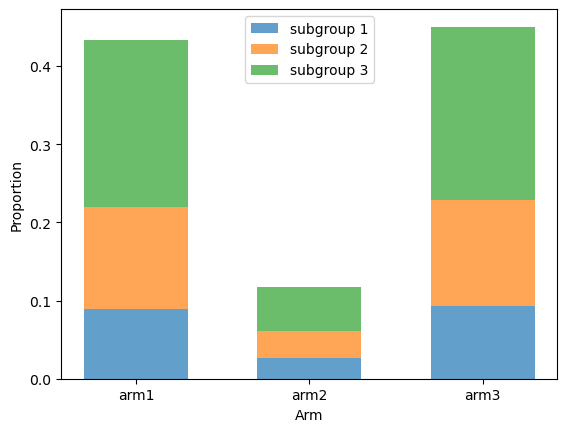

In [23]:
import matplotlib.pyplot as plt

mean_props = np.mean(draw_props,axis=0)

# Create some sample data
labels = ['arm1','arm2','arm3']
w0 = mean_props[:,0]
w1 = mean_props[:,1]
w2 = mean_props[:,2]


# Plot the bars
plt.bar(labels, w0, label='subgroup 1',alpha=0.7, width=0.6)
plt.bar(labels, w1, bottom=w0, label='subgroup 2', alpha=0.7, width=0.6)
plt.bar(labels, w2, bottom=w0+w1, label='subgroup 3', alpha=0.7, width=0.6)

# Add a legend and labels
plt.legend()
plt.xlabel('Arm')
plt.ylabel('Proportion')

# Show the plot
plt.show()